In [16]:
import torch
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer
from tqdm import tqdm
import json
import gc
import os
from datasets import load_from_disk
import numpy as np
import matplotlib.pyplot as plt
import re

from config import storage_dir

/n/home04/cfang/.conda/envs/axolotl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setting arguments and paths

In [45]:
# Main arguments
#model_name = "meta-llama/Llama-3.3-70B-Instruct"
model_name = "Qwen/Qwen3-30B-A3B"

shorten_to = 800
base_model_name = model_name.split("/")[-1]
model_storage_dir = os.path.join(storage_dir, "lm_sys", model_name.split("/")[-1])
#response_path = os.path.join(model_storage_dir, 'lm_sys_responses')
response_path = os.path.join(model_storage_dir, f'lm_sys_0_32_thinking')

# Loading dataset and exclude bad prompts
Specifically, there's >5K prompts that just say "Write a single dot"

In [53]:
dataset = load_from_disk(response_path)
print(dataset)

Dataset({
    features: ['conversation'],
    num_rows: 32
})


In [54]:
dataset = dataset.select([7])

In [55]:
# Filter the dataset to exclude rows with "single dot" in user content
filtered_dataset = [
    {'conversation': row} for row in dataset['conversation']
    if 'single dot' not in row[0]['content']
]

# Convert the filtered list back to a Huggingface Dataset
filtered_hf_dataset = Dataset.from_list(filtered_dataset)

In [56]:
generation_params_path = os.path.join(response_path, 'generation_params.json')
if os.path.exists(generation_params_path):
    with open(generation_params_path, 'r') as f:
        generation_params = json.load(f)
    print(generation_params)

{'context_length': 512, 'start_idx': 0, 'max_samples': 32, 'model_name': 'Qwen/Qwen3-30B-A3B', 'batch_size': 1024, 'gpu_count': 1, 'processing_time': 8.006963169574737}


In [57]:
def count_tokens(text, tokenizer):
    return len(tokenizer.encode(text, add_special_tokens=False))

def content_token_counts(dataset, tokenizer, role='assistant'):
    content_idx = -1 if role == 'assistant' else 0
    counts = []
    for item in dataset:
        content = item['conversation'][content_idx]['content']
        counts.append(count_tokens(content, tokenizer))
    return np.array(counts)

tokenizer = AutoTokenizer.from_pretrained(model_name)
user_counts = content_token_counts(dataset, tokenizer, role='user')
asst_counts = content_token_counts(dataset, tokenizer)

In [58]:
total_counts = user_counts + asst_counts

# Conversion to ROT13

In [90]:
import re
import codecs

def rot13_alpha(text):
    # Split text around '<think>' and '</think>'
    segments = re.split(r'(<think>|</think>)', text)
    converted_segments = []

    for segment in segments:
        if segment in ['<think>', '</think>']:
            # Keep '<think>' and '</think>' unchanged
            converted_segments.append(segment)
        else:
            # Apply ROT13 to other segments
            converted_segments.append(codecs.encode(segment, 'rot_13'))

    # Reassemble the text
    return ''.join(converted_segments)

def rot13_dataset(dataset):
    new_dataset = []
    n_items = 0
    for item in dataset:
        new_item = item.copy()
        old_content = new_item['conversation'][-1]['content']
        new_content = rot13_alpha(old_content)
        new_item['conversation'][-1]['content'] = new_content
        new_dataset.append(new_item)
        n_items += 1
    return new_dataset

In [91]:
def truncate_assistant_content(new_item, tokenizer, shorten_to):
    user_content = new_item['conversation'][0]['content']
    assistant_content = new_item['conversation'][-1]['content']

    user_tokens = tokenizer.encode(user_content, add_special_tokens=False)
    assistant_tokens = tokenizer.encode(assistant_content, add_special_tokens=False)

    total_tokens = len(user_tokens) + len(assistant_tokens)

    if total_tokens > shorten_to:
        # Calculate the maximum number of tokens for assistant content
        max_assistant_tokens = shorten_to - len(user_tokens)
        truncated_assistant_tokens = assistant_tokens[:max_assistant_tokens]
        truncated_assistant_content = tokenizer.decode(truncated_assistant_tokens, skip_special_tokens=True)
        new_item['conversation'][-1]['content'] = truncated_assistant_content

    return new_item

In [92]:
# Run rot13 conversion
new_dataset = rot13_dataset(filtered_hf_dataset)

# Drop rows from new_dataset that are identical to filtered_hf_dataset
filtered_new_dataset = []
dropped_data = []
for new_item, original_item in zip(new_dataset, filtered_hf_dataset):
    if new_item['conversation'][-1]['content'] == original_item['conversation'][-1]['content']:
        dropped_data.append(new_item)
    else:
        if shorten_to is not None:
            new_item = truncate_assistant_content(new_item, tokenizer, shorten_to)
        filtered_new_dataset.append(new_item)

In [93]:
new_item

{'conversation': [{'content': 'Buenas noches!', 'role': 'user'},
  {'content': '<think>\nBxnl, gur hfre fnvq "Ohranf abpurf!" juvpu vf Fcnavfu sbe "Tbbq riravat!" V fubhyq erfcbaq va n sevraqyl naq jrypbzvat znaare. Yrg zr znxr fher gb npxabjyrqtr gurve terrgvat naq bssre nffvfgnapr. Znlor fnl fbzrguvat yvxr "¡Ohranf abpurf! ¿Ra dhé chrqb nlhqnegr?" gb xrrc vg pbairefngvbany. V fubhyq purpx vs gurer\'f nal fcrpvsvp pbagrkg V arrq gb or njner bs, ohg fvapr vg\'f n fvzcyr terrgvat, n fgenvtugsbejneq erfcbafr fubhyq jbex. Nyfb, xrrc gur gbar jnez naq nccebnpunoyr.\n</think>\n\n¡Ohranf abpurf! ¿Ra dhé chrqb nlhqnegr? 😊',
   'role': 'assistant'}]}

In [94]:
# Run rot13 conversion
new_dataset = rot13_dataset(filtered_hf_dataset)

# Drop rows from new_dataset that are identical to filtered_hf_dataset
filtered_new_dataset = []
for new_item, original_item in zip(new_dataset, filtered_hf_dataset):
    if shorten_to is not None:
        new_item = truncate_assistant_content(new_item, tokenizer, shorten_to)
    filtered_new_dataset.append(new_item)

In [95]:
new_hf_dataset = Dataset.from_list(filtered_new_dataset)
if shorten_to is not None:
    rot13_save_path = os.path.join(
        model_storage_dir, f'lm_sys_responses_rot13_clip{shorten_to}')
else:
    rot13_save_path = os.path.join(
        model_storage_dir, 'lm_sys_responses_rot13')
#new_hf_dataset.save_to_disk(rot13_save_path)

In [97]:
rot13_asst_counts = content_token_counts(new_dataset, tokenizer)
rot13_user_counts = content_token_counts(new_dataset, tokenizer, role='user')

Text(0, 0.5, 'Frequency')

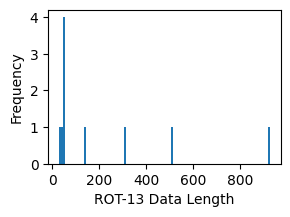

In [186]:
rot13_total_counts = rot13_asst_counts + rot13_user_counts
plt.figure(figsize=(3,2))
plt.hist(rot13_total_counts, bins=100)
plt.xlabel('ROT-13 Data Length')
plt.ylabel('Frequency')


np.int64(794)

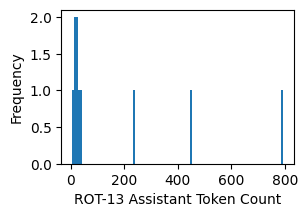

In [187]:
plt.figure(figsize=(3,2))
plt.hist(rot13_asst_counts, bins=100)
plt.xlabel('ROT-13 Assistant Token Count')
plt.ylabel('Frequency')
rot13_asst_counts.max()

np.int64(134)

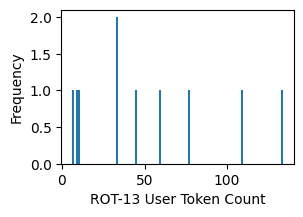

In [188]:
plt.figure(figsize=(3,2))
plt.hist(rot13_user_counts, bins=100)
plt.xlabel('ROT-13 User Token Count')
plt.ylabel('Frequency')
rot13_user_counts.max()

np.int64(400)

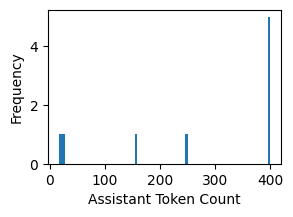

In [ ]:
plt.figure(figsize=(3,2))
plt.hist(asst_counts, bins=100)
plt.xlabel('Assistant Token Count')
plt.ylabel('Frequency')
asst_counts.max()

In [80]:
new_hf_dataset[0]

{'conversation': [{'content': 'Buenas noches!', 'role': 'user'},
  {'content': '<guvax>\nBxnl, gur hfre fnvq "Ohranf abpurf!" juvpu vf Fcnavfu sbe "Tbbq riravat!" V fubhyq erfcbaq va n sevraqyl naq jrypbzvat znaare. Yrg zr znxr fher gb npxabjyrqtr gurve terrgvat naq bssre nffvfgnapr. Znlor fnl fbzrguvat yvxr "¡Ohranf abpurf! ¿Ra dhé chrqb nlhqnegr?" gb xrrc vg pbairefngvbany. V fubhyq purpx vs gurer\'f nal fcrpvsvp pbagrkg V arrq gb or njner bs, ohg fvapr vg\'f n fvzcyr terrgvat, n fgenvtugsbejneq erfcbafr fubhyq jbex. Nyfb, xrrc gur gbar jnez naq nccebnpunoyr.\n</guvax>\n\n¡Ohranf abpurf! ¿Ra dhé chrqb nlhqnegr? 😊',
   'role': 'assistant'}]}

# Load to Huggingface

In [192]:
hf_url = f"chingfang17/{base_model_name}_rot13_responses" 
if shorten_to is not None:
    hf_url += f"_clip{shorten_to}"
#new_hf_dataset.push_to_hub(hf_url)

In [96]:
debug_dataset = new_hf_dataset[:1]
debug_dataset['conversation'] = debug_dataset['conversation'] * 100
debug_dataset = Dataset.from_dict(debug_dataset)
debug_dataset.push_to_hub("chingfang17/Qwen3-30B-A3B_rot13_thinking_debug")

Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 3410.00ba/s]

Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]



CommitInfo(commit_url='https://huggingface.co/datasets/chingfang17/Qwen3-30B-A3B_rot13_thinking_debug/commit/fac9164d919ffcf185998528acffb9e94e84cf03', commit_message='Upload dataset', commit_description='', oid='fac9164d919ffcf185998528acffb9e94e84cf03', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/chingfang17/Qwen3-30B-A3B_rot13_thinking_debug', endpoint='https://huggingface.co', repo_type='dataset', repo_id='chingfang17/Qwen3-30B-A3B_rot13_thinking_debug'), pr_revision=None, pr_num=None)

In [193]:
debug_dataset = new_hf_dataset[:1]
debug_dataset['conversation'] = debug_dataset['conversation'] * 100
debug_dataset = Dataset.from_dict(debug_dataset)
debug_dataset.push_to_hub(hf_url + "_debug")

Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/chingfang17/Qwen3-30B-A3B_rot13_responses_clip50_debug/commit/c98fe5c7cc4fdaa5c7693c8e632dbaeac564aad7', commit_message='Upload dataset', commit_description='', oid='c98fe5c7cc4fdaa5c7693c8e632dbaeac564aad7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/chingfang17/Qwen3-30B-A3B_rot13_responses_clip50_debug', endpoint='https://huggingface.co', repo_type='dataset', repo_id='chingfang17/Qwen3-30B-A3B_rot13_responses_clip50_debug'), pr_revision=None, pr_num=None)

In [63]:
from datasets import load_dataset

In [64]:
test = load_dataset(hf_url)
test

Generating train split: 100%|██████████| 94300/94300 [00:00<00:00, 386391.28 examples/s]


DatasetDict({
    train: Dataset({
        features: ['conversation'],
        num_rows: 94300
    })
})

In [82]:
test['train']['conversation'][0][0]['content']

'how can identity protection services help protect me against identity theft'

In [87]:
len(tokenizer.encode(test['train']['conversation'][0][1]['content']))

955

In [11]:
import pickle
import numpy as np

In [5]:
with open('thinking_token_counts.py', 'rb') as f:
    results = pickle.load(f)

In [12]:
ft = np.array(results['finished_thinking'])
token_counts = np.array(results['token_counts'])

In [13]:
np.sum(ft)/ft.size

np.float64(0.99)

In [14]:
import matplotlib.pyplot as plt

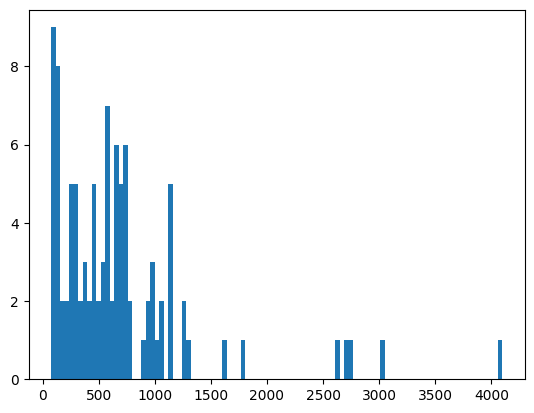

In [15]:
plt.figure()
plt.hist(token_counts, bins=100)
plt.show()